# Continual learning - Rehearsal approch

A small experiment with a convolutional network on MNIST and FashionMNIST datasets. The goal is to train the network on MNIST and then on FashionMNIST. The network should be able to learn both datasets without forgetting the first one. 

Compared to the previous experience, we adopt a rehearsal approach. At the end of each epoch when training on FashionMNIST, we train the model on 1 batch of data from MNIST.

One disadvantage is that we need to keep in memory examples from previous task.

In [51]:
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, log_loss
import numpy as np

In [52]:
subsample = 10_000
batch_size = 128

mnist_epochs = 15
fashion_epochs = 15

mnist = True
fashion = True
rehearsal = True

In [53]:
# import MNIST
mnist_train_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(mnist_train_data.data.shape)

# sample subsample images
# train_data = torch.utils.data.Subset(train_data, range(subsample))
# test_data = torch.utils.data.Subset(test_data, range(subsample))
mnist_train_dataloader = DataLoader(
    mnist_train_data, batch_size=batch_size, shuffle=True
)
mnist_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [54]:
size = len(mnist_train_data)
idxs = np.arange(size)
np.random.shuffle(idxs)

In [55]:
rehearsal_dataloader = DataLoader(mnist_train_data, batch_size=batch_size, shuffle=True)

In [56]:
# import FashionMNIST
train_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(train_data.data.shape)

# sample subsample images
# train_data = torch.utils.data.Subset(train_data, range(subsample))
# test_data = torch.utils.data.Subset(test_data, range(subsample))
fashion_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
fashion_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [57]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12 * 12 * 32, 128)
        self.fc2 = nn.Linear(128, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        # convolutions
        x = self.conv1(x)
        x = self.max_pool(self.conv2(x))
        # classifier
        x = x.view(-1, 12 * 12 * 32)
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        return torch.softmax(self.fc2(x), dim=1)

In [58]:
def evaluate_mnist(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long)
    y_test = torch.empty(0, dtype=torch.long)
    for _, (X_batch, y_batch) in enumerate(mnist_test_dataloader):
        output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    if verbose:
        print("MNIST - F1 score", f1_score(y_test, y_pred, average="macro"))
    return f1_score(y_test, y_pred, average="macro")

In [59]:
def evaluate_fashion(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long)
    y_test = torch.empty(0, dtype=torch.long)
    for _, (X_batch, y_batch) in enumerate(fashion_test_dataloader):
        output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    if verbose:
        print("Fashion - F1 score", f1_score(y_test, y_pred, average="macro"))
    return f1_score(y_test, y_pred, average="macro")

In [60]:
cnn = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

mnist_scores = []
fashion_scores = []

# MNIST
mnist_losses = []
if mnist:
    print("--- MNIST ---")
    cnn.train()
    for epoch in range(mnist_epochs):
        for _, (X_batch, y_batch) in enumerate(mnist_train_dataloader):
            optimizer.zero_grad()
            output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} - loss", loss.item())
        mnist_losses.append(loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))

    print("--- Scores ---")
    evaluate_fashion()
    evaluate_mnist()

--- MNIST ---
Epoch 0 - loss 1.573501467704773
Epoch 1 - loss 1.46621572971344
Epoch 2 - loss 1.4935460090637207
Epoch 3 - loss 1.5094934701919556
Epoch 4 - loss 1.4721031188964844
Epoch 5 - loss 1.472331166267395
Epoch 6 - loss 1.4721101522445679
Epoch 7 - loss 1.4611951112747192
Epoch 8 - loss 1.471707820892334
Epoch 9 - loss 1.4664506912231445
Epoch 10 - loss 1.464025616645813
Epoch 11 - loss 1.4611543416976929
Epoch 12 - loss 1.4622139930725098
Epoch 13 - loss 1.4928981065750122
Epoch 14 - loss 1.461150050163269
--- Scores ---
Fashion - F1 score 0.05807257635226106
MNIST - F1 score 0.9817788816285761


In [63]:
rehearsal_iter = iter(rehearsal_dataloader)

In [64]:
# FashionMNIST
if fashion:
    print("--- FashionMNIST ---")

    cnn.train()
    for epoch in range(fashion_epochs):
        for _, (X_batch, y_batch) in enumerate(fashion_train_dataloader):
            optimizer.zero_grad()
            output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        if rehearsal:
            # at the end of an epoch, retrain on random samples from MNIST
            X_batch, y_batch = next(rehearsal_iter)
            optimizer.zero_grad()
            output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))
        print(f"Epoch {epoch} - loss", loss.item())

    print("--- Scores ---")
    evaluate_mnist()
    evaluate_fashion()

--- FashionMNIST ---
Epoch 0 - loss 2.002872943878174
Epoch 1 - loss 1.8513586521148682
Epoch 2 - loss 1.720594882965088
Epoch 3 - loss 1.8200469017028809
Epoch 4 - loss 1.9414029121398926
Epoch 5 - loss 1.8218204975128174
Epoch 6 - loss 2.0072548389434814
Epoch 7 - loss 1.8435057401657104
Epoch 8 - loss 1.7667417526245117
Epoch 9 - loss 1.8765274286270142
Epoch 10 - loss 1.8401862382888794
Epoch 11 - loss 1.9390755891799927
Epoch 12 - loss 1.9804574251174927
Epoch 13 - loss 2.0606133937835693
Epoch 14 - loss 1.9130058288574219
--- Scores ---
MNIST - F1 score 0.5448806606879052
Fashion - F1 score 0.8753399284949062


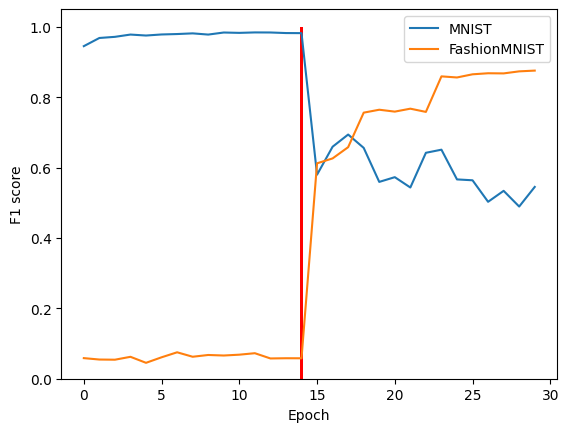

In [68]:
plt.figure()
plt.plot(mnist_scores, label="MNIST")
plt.plot(fashion_scores, label="FashionMNIST")
plt.bar(mnist_epochs - 1, height=1, width=0.2, color="r")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.legend()
# savefig
plt.savefig("results_cnn_rehearsal.png")
plt.show()